<a href="https://colab.research.google.com/github/GiuliaTuccio/ScalableML-DL/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Final Project**


In this project we build a reccomandation system for music based on the notion of spectogram; a picture created starting by an mp3 file, and representing the frequences with respect to time.

The mp3 file are downloaded on the page https://github.com/mdeff/fma, containing 8000 songs, belonging to one of the 8 following genres:
1. Hip-Hop
2. International
3. Electronic
4. Folk
5. Experimental
6. Rock
7. Pop
8. Instrumental

As soon as the spectograms are generated, we proceed into cutting the images into the desired shape (128x128) and converting them into greyscale.

Successively, we build the classification network and proceed with the training.

Finnally, we discerd the last layer (producing the classification of the songs), keeping the dense layer made by 32-features vector.
The features will be used to compute the reccomondation system based on the cosine similarity, between a song inputed by the user and the 'Test' set.

Importing the necessary libraries

In [1]:
!pip install tensorflow

import os
import pandas as pd
import re
import math
import numpy as np
import soundfile as sf
from PIL import Image
import librosa
import librosa.display
import matplotlib.pyplot as plt
from PIL import Image 
from keras.models import Sequential
from keras import initializers
from keras import optimizers
from keras.layers import *
from keras.utils.vis_utils import plot_model

import cv2
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

In [2]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

Importing Google Drive, where the songs are saved

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


Uploading the excel file containing the information about the songs.

The first column contains the id, whereas the 41st column defines the genre of the song

In [ ]:
# Upload the data set containing the informations about the songs

filename_metadata = "/content/gdrive/MyDrive/tracks.csv"
tracks = pd.read_csv(filename_metadata, header=2)

print(tracks['Unnamed: 40'].value_counts())

Rock                   14182
Experimental           10608
Electronic              9372
Hip-Hop                 3552
Folk                    2803
Pop                     2332
Instrumental            2079
International           1389
Classical               1230
Jazz                     571
Old-Time / Historic      554
Spoken                   423
Country                  194
Soul-RnB                 175
Blues                    110
Easy Listening            24
Name: Unnamed: 40, dtype: int64


In [ ]:
tracks_array = tracks.values

# extract the information
tracks_id_array = tracks_array[: , 0]
tracks_genre_array = tracks_array[: , 40]

# save the id and the genre in an array
tracks_id_array = tracks_id_array.reshape(tracks_id_array.shape[0], 1)

tracks_genre_array = tracks_genre_array.reshape(tracks_genre_array.shape[0], 1)

The following code is a trial for one folder.

Firstly, a directory cointaining the spectogram images is created.

Then, a loop goes through each of the mp3 files, saves the index and the genre, and uses the library librosa to generate the spectogram.

The spectogram is then converted in decibel units (melspectogram) and saved as a jpg image.

In [ ]:
if not os.path.exists('/content/gdrive/MyDrive/Train_Spectogram_Images_000'):
            os.makedirs('/content/gdrive/MyDrive/Train_Spectogram_Images_000')

folder_sample = '/content/gdrive/MyDrive/music-data/000'
            

file_names = [os.path.join(folder_sample, f)
                  for f in os.listdir(folder_sample)
                  if f.endswith(".mp3")]

count = 0
           
for f in file_names:
    #track_id = int(re.search('/content/gdrive/MyDrive/music-data/.*/(.+?).mp3', f).group(1))
    track_id = int(re.search('/content/gdrive/MyDrive/music-data/000/(.+?).mp3', f).group(1))
    print(track_id)
    idx = list(tracks_id_array).index(track_id)
    if(str(tracks_genre_array[idx, 0]) != '0'):
      print(f)
    # returns audio time series and sampling rate
    y, sr =  librosa.load(f)
    # Display of mel-frequency spectrogram coefficients
    melspectrogram_array = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    # Convert a power spectrogram (amplitude squared) to decibel (dB) units
    mel = librosa.power_to_db(melspectrogram_array)
    # Save the images of the spectogram
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = float(mel.shape[1]) / float(100)
    fig_size[1] = float(mel.shape[0]) / float(100)
    plt.rcParams["figure.figsize"] = fig_size
    plt.axis('off')
    plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
    librosa.display.specshow(mel, cmap='gray_r')
    plt.savefig("/content/gdrive/MyDrive/Train_Spectogram_Images_000/"+str(count)+"_"+str(tracks_genre_array[idx,0])+".jpg", bbox_inches=None, pad_inches=0)
    plt.close()
    count += 1

Here the same procedure is replicated for all the mp3 files in the dataset

In [ ]:
# count = 0
# if not os.path.exists('/content/Train_Spectogram_Images'):
#             os.makedirs('/content/Train_Spectogram_Images')

# folder_sample = '/content/gdrive/MyDrive/music-data'
# directories = [d for d in os.listdir(folder_sample)
#                  if os.path.isdir(os.path.join(folder_sample, d))]
              
# for d in directories:
#     label_directory = os.path.join(folder_sample, d)
#     file_names = [os.path.join(label_directory, f)
#                   for f in os.listdir(label_directory)
#                   if f.endswith(".mp3")]
            
#     for f in file_names:
#         print(file_names)
#         track_id = int(re.search('/content/gdrive/MyDrive/music-data/000/(.+?).mp3', f).group(1))
#         print(track_id)
#         #print(track_id)
#         idx = list(tracks_id_array).index(track_id)
#         # returns audio time series and sampling rate
#         y, sr =  librosa.load(f)
#         # Display of mel-frequency spectrogram coefficients
#         melspectrogram_array = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
#         # Convert a power spectrogram (amplitude squared) to decibel (dB) units
#         mel = librosa.power_to_db(melspectrogram_array)
#         # Save the images of the spectogram
#         fig_size = plt.rcParams["figure.figsize"]
#         fig_size[0] = float(mel.shape[1]) / float(100)
#         fig_size[1] = float(mel.shape[0]) / float(100)
#         plt.rcParams["figure.figsize"] = fig_size
#         plt.axis('off')
#         plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
#         librosa.display.specshow(mel, cmap='gray_r')
#         plt.savefig("'/content/Train_Spectogram_Images'"+str(count)+"-"+str(tracks_genre_array[idx,0])+".jpg", bbox_inches=None, pad_inches=0)
#         plt.close()
#         count += 1

The spectograms created are then converted into a picture of the desired dimensions. 

This means that all the images are cropped. The genre is saved as the name of the image.

In [ ]:
# Create folder for sliced images
if not os.path.exists('/content/Train_Sliced_Images'):
            os.makedirs('/content/Train_Sliced_Images')

DEF_SIZE = 128

folder_sample = '/content/gdrive/MyDrive/Train_spectogram_Images'
directories = [d for d in os.listdir(folder_sample)
                 if os.path.isdir(os.path.join(folder_sample, d))]
counter = 0             
for d in directories:
    label_directory = os.path.join(folder_sample, d)
    file_names = [os.path.join(label_directory, f)
                  for f in os.listdir(label_directory)
                  if f.endswith(".jpg")]
            
    for f in file_names:
      genre = re.search('/content/gdrive/MyDrive/Train_spectogram_Images/.*/.*_(.+?).jpg', f).group(1)
      #print(genre)
      img = Image.open(f)
      w, h = img.size
      # understand how many sliced images for each spectogram
      num_slices = w // DEF_SIZE
      for i in range(num_slices):
        left_ = i*DEF_SIZE  
        img_sliced = img.crop((left_, 0., left_+DEF_SIZE, DEF_SIZE)) # left, top, right, bottom
        img_sliced.save("/content/Train_Sliced_Images/"+str(counter)+"_"+genre+".jpg")
        counter += 1
        #print(counter)

Output streaming troncato alle ultime 5000 righe.
44792
44793
44794
44795
44796
44797
44798
44799
44800
44801
44802
44803
44804
44805
44806
44807
44808
44809
44810
44811
44812
44813
44814
44815
44816
44817
44818
44819
44820
44821
44822
44823
44824
44825
44826
44827
44828
44829
44830
44831
44832
44833
44834
44835
44836
44837
44838
44839
44840
44841
44842
44843
44844
44845
44846
44847
44848
44849
44850
44851
44852
44853
44854
44855
44856
44857
44858
44859
44860
44861
44862
44863
44864
44865
44866
44867
44868
44869
44870
44871
44872
44873
44874
44875
44876
44877
44878
44879
44880
44881
44882
44883
44884
44885
44886
44887
44888
44889
44890
44891
44892
44893
44894
44895
44896
44897
44898
44899
44900
44901
44902
44903
44904
44905
44906
44907
44908
44909
44910
44911
44912
44913
44914
44915
44916
44917
44918
44919
44920
44921
44922
44923
44924
44925
44926
44927
44928
44929
44930
44931
44932
44933
44934
44935
44936
44937
44938
44939
44940
44941
44942
44943
44944
44945
44946
44947
44948
44949
44

The images are then saved as npy files, easier to manage.

The labels are converted in one-hot encoding and splitted into train and test sets.

In [ ]:
# Convert the data set into grey-scale images and associate it with the label for the training phase

## TO DO CREATE FUNCTION LOAD DATA SET
genre = {
        "Hip-Hop": 0,
        "International": 1,
        "Electronic": 2,
        "Folk" : 3,
        "Experimental": 4,
        "Rock": 5,
        "Pop": 6,
        "Instrumental": 7
        }

spectogram_images = [os.path.join('/content/Train_Sliced_Images', f)
                          for f in os.listdir('/content/Train_Sliced_Images')
                          if f.endswith(".jpg")]


images_all = [None]*(len(spectogram_images))
labels_all = [None]*(len(spectogram_images))


In [ ]:
print(len(spectogram_images))
for f in spectogram_images:
    idx = int(re.search('/content/Train_Sliced_Images/(.+?)_.*.jpg', f).group(1))
    genre_var = re.search('/content/Train_Sliced_Images/.*_(.+?).jpg', f).group(1)
    
    temp = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    images_all[idx] = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    labels_all[idx] = genre[genre_var]
    

49791


In [ ]:
images = np.array(images_all)
labels = np.array(labels_all)
labels = labels.reshape(labels.shape[0],1)
train_x, test_x, train_y, test_y = train_test_split(images, labels, test_size=0.1, shuffle=True)

In [ ]:
# Convert the labels into one-hot vectors.
n_classes = len(genre)
train_y = np_utils.to_categorical(train_y, num_classes=n_classes)
test_y = np_utils.to_categorical(test_y, num_classes=n_classes)

genre_new = {value: key for key, value in genre.items()}



In [ ]:
if os.path.exists('/content/gdrive/MyDrive/Training_Data_Giulia'):
    train_x = np.load("/content/gdrive/MyDrive/Training_Data_Giulia/train_x.npy")
    train_y = np.load("/content/gdrive/MyDrive/Training_Data_Giulia/train_y.npy")
    test_x = np.load("/content/gdrive/MyDrive/Training_Data_Giulia/test_x.npy")
    test_y = np.load("/content/gdrive/MyDrive/Training_Data_Giulia/test_y.npy")
    

if not os.path.exists('/content/gdrive/MyDrive/Training_Dat_Giuliaa'):
    os.makedirs('/content/gdrive/MyDrive/Training_Data_Giulia')
np.save("/content/gdrive/MyDrive/Training_Data_Giulia/train_x.npy", train_x)
np.save("/content/gdrive/MyDrive/Training_Data_Giulia/train_y.npy", train_y)
np.save("/content/gdrive/MyDrive/Training_Data_Giulia/test_x.npy", test_x)
np.save("/content/gdrive/MyDrive/Training_Data_Giulia/test_y.npy", test_y)

The following model is over-fitting, since it performs well in terms of the training set, but it performs very pooorly in the validation data set.
We will try to improve the performance by modifying the architecture

In [20]:
train_x = np.load('/content/gdrive/MyDrive/Training_Data_Giulia/train_x.npy')
test_x = np.load('/content/gdrive/MyDrive/Training_Data_Giulia/test_x.npy')
train_y = np.load('/content/gdrive/MyDrive/Training_Data_Giulia/train_y.npy')
test_y = np.load('/content/gdrive/MyDrive/Training_Data_Giulia/test_y.npy')

In [21]:
train_y.shape, train_x.shape

((44811, 8), (44811, 128, 128))

In [22]:
train_x_1, val_x, train_y_1, val_y = train_test_split(train_x, train_y, test_size=0.10, shuffle=True)

In [23]:
val_x.shape, val_y.shape


((4482, 128, 128), (4482, 8))

To shuffle also the validation set

In [24]:
# Expand the dimensions of the image to have a channel dimension. (nx128x128) ==> (nx128x128x1)
train_x_1 = train_x_1.reshape(train_x_1.shape[0], train_x_1.shape[1], train_x_1.shape[2], 1)
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1)
val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2], 1)

# # Normalize the matrices.
# train_x_1 = train_x_1 / 255.
# val_x = val_x / 255.
# test_x = test_x / 255.

1. prova con early stopping
2. aggiungi regularization layers

In [25]:
# import regularizer
from keras import regularizers
from keras.regularizers import l2
from keras import layers

In [27]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x_1, train_y_1))
val_ds = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
train_ds

<PrefetchDataset shapes: ((128, 128, 1), (8,)), types: (tf.uint8, tf.float32)>

In [31]:
normalization_layer = layers.Rescaling(1./255)
val_ds = val_ds.batch(128).map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.batch(128).map(lambda x, y: (normalization_layer(x), y))

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8)
save_best_model = ModelCheckpoint(filepath='model_.{epoch:02d}_{val_loss:.2f}.hdf5', verbose=1,
        monitor='val_loss')


In [ ]:
if not os.path.exists('Saved_Model'):
  os.mkdir('Saved_Model')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
save_best_model = ModelCheckpoint(filepath='model_.{epoch:02d}_{val_loss:.2f}.hdf5', verbose=1,
        monitor='val_loss')


model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, strides=2, activation='elu',kernel_initializer='glorot_normal',kernel_regularizer=regularizers.l2(0.0001), input_shape=(128,128,1)))
model.add(MaxPooling2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=128, kernel_size=2, strides=2, activation='elu',kernel_regularizer=regularizers.l2(0.0001), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=256, kernel_size=2, strides=2, activation='elu', kernel_regularizer=regularizers.l2(0.0001),kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=512, kernel_size=2, strides=2, activation='elu', kernel_regularizer=regularizers.l2(0.0001),kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2, padding='same'))

model.add(Flatten())
model.add(Dropout(0.6))

model.add(Dense(256))

model.add(Activation('elu'))
model.add(Dropout(0.5))

model.add(Dense(128))

model.add(Activation('elu'))
model.add(Dropout(0.25))

model.add(Dense(32))
model.add(Activation('elu'))

model.add(Dense(8))
model.add(Activation('softmax'))

print(model.summary())

# Save the model architecture
#plot_model(model, to_file="/content/Saved_Model/Model_Architecture.jpg", show_shapes=True)


model.compile(loss='categorical_crossentropy',
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics = ['accuracy'])

history = model.fit(train_ds, epochs=30, batch_size=128, verbose=1, validation_data=val_ds, callbacks=[early_stopping, save_best_model])
pd.DataFrame(history.history).to_csv("Saved_Model/training_history.csv")
score = model.evaluate(test_x, test_y, verbose=1)
print(score)
model.save("Saved_Model/Model.h5")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       32896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         131328    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 256)       

KeyboardInterrupt: ignored

In [ ]:
if not os.path.exists('Saved_Model_4nd'):
  os.mkdir('Saved_Model_4nd')



model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, strides=2, activation='relu', input_shape=(128,128,1)))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=128, kernel_size=2, strides=2, activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=256, kernel_size=2, strides=2, activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=512, kernel_size=2, strides=2, activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=2, padding='same'))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256))

model.add(Activation('elu'))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation('elu'))
model.add(Dropout(0.25))

model.add(Dense(32))
model.add(Activation('elu'))
model.add(Dropout(0.2))

model.add(Dense(8))
model.add(Activation('softmax'))

print(model.summary())

# Save the model architecture
plot_model(model, to_file="/content/Saved_Model_4nd/Model_Architecture.jpg", show_shapes=True)

model.compile(loss='categorical_crossentropy',
             optimizer = tf.keras.optimizers.RMSprop(),
             metrics = ['accuracy'])

history = model.fit(train_ds, epochs=50, verbose=1,  validation_data=val_ds, callbacks=[early_stopping, save_best_model])
score = model.evaluate(test_ds, verbose=1)
print(score)
model.save("Saved_Model_4nd/Model.h5")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 64, 64, 64)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 average_pooling2d_5 (Averag  (None, 32, 32, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 128)       32896     
                                                                 
 batch_normalization_7 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                      

KeyboardInterrupt: ignored

Here I am not using data augmentation

In [33]:
train_ds = train_ds.batch(128).map(lambda x, y: (normalization_layer(x), y))

In [34]:
train_ds

<MapDataset shapes: ((None, 128, 128, 1), (None, 8)), types: (tf.float32, tf.float32)>

In [35]:
if not os.path.exists('/content/gdrive/MyDrive/Saved_Model_Batch'):
  os.mkdir('/content/gdrive/MyDrive/Saved_Model_Batch')


# HERE WE TRY TO IMPROVE THE PREVIOUS RESULT BY ADDING A BATCH NORMALIZATION LAYER AFTER
# EACH CONVOLUTIONAL LAYER


model = Sequential()
model.add(Conv2D(filters=64, kernel_size=[7,7], activation="relu", kernel_regularizer=regularizers.l2(0.0001), input_shape=(128,128,1)))
# Dim = (122x122x64)
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=[2,2], strides=2))
# Dim = (61x61x64)
model.add(Conv2D(filters=128, kernel_size=[7,7], strides=2, kernel_regularizer=regularizers.l2(0.0001), activation="relu"))
# Dim = (28x28x128)
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=[2,2], strides=2))
# Dim = (14x14x128)
model.add(Conv2D(filters=256, kernel_size=[3,3], kernel_regularizer=regularizers.l2(0.0001), activation="relu"))
# Dim = (12x12x256)
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=[2,2], strides=2))
# Dim = (6x6x256)
model.add(Conv2D(filters=512, kernel_size=[3,3], kernel_regularizer=regularizers.l2(0.0001), activation="relu"))
# Dim = (4x4x512)
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=[2,2], strides=2))
# Dim = (2x2x512)
model.add(BatchNormalization())
model.add(Flatten())
# Dim = (2048)
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(1024, activation="elu"))
# Dim = (1024)
model.add(Dropout(0.5))
model.add(Dense(256, activation="elu"))
# Dim = (256)
model.add(Dropout(0.25))
model.add(Dense(64, activation="elu"))
# Dim = (64)
model.add(Dense(32, activation="elu"))
# Dim = (32)
model.add(Dense(8, activation="softmax"))
# Dim = (8)
print(model.summary())


# compile
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

# Save the training history
history = model.fit(train_ds, epochs=50, verbose=1,  validation_data=val_ds)
#pd.DataFrame(model.fit(train_x, train_y, batch_size=64, epochs=5, verbose=1, validation_split=0.1).history).to_csv("/content/gdrive/MyDrive/Saved_Model_Batch/training_history.csv")

# evaluate on the test set
score = model.evaluate(test_ds, verbose=1)
print(score)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 122, 122, 64)      3200      
                                                                 
 batch_normalization_6 (Batc  (None, 122, 122, 64)     256       
 hNormalization)                                                 
                                                                 
 average_pooling2d_4 (Averag  (None, 61, 61, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       401536    
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                                 
                                                      

In [36]:
# save the training history
pd.DataFrame(history.history).to_csv('/content/gdrive/MyDrive/Saved_Model_Batch/my_model_50.csv')

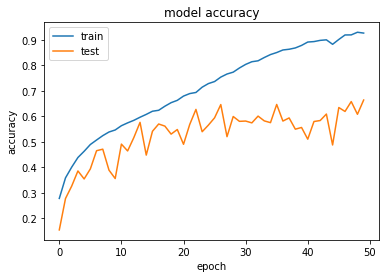

In [38]:
# show the learning curves

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

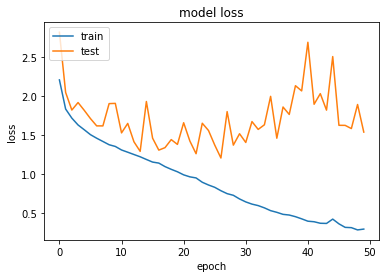

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
# save the model
model.save('/content/gdrive/MyDrive/Saved_Model_Batch/Model.h5')

Now we can try to improve the performance by performing data augmentation

In [ ]:
train_ds_aug = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [26]:
# augment the training dataset

data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest")
    ])

train_ds_aug = train_ds_aug.batch(128).map(lambda x, y: (data_augmentation(x), y))


In [ ]:
# check the dimensions
train_ds_aug

In [ ]:
if not os.path.exists('/content/gdrive/MyDrive/Saved_Model_Aug'):
  os.mkdir('/content/gdrive/MyDrive/Saved_Model_Aug')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
save_best_model = ModelCheckpoint(filepath='model_.{epoch:02d}_{val_loss:.2f}.hdf5', verbose=1,
        monitor='val_loss', save_best_only=True,)

# HERE WE TRY TO IMPROVE THE PREVIOUS RESULT BY ADDING A BATCH NORMALIZATION LAYER AFTER
# EACH CONVOLUTIONAL LAYER


model_aug = Sequential()
model_aug.add(Conv2D(filters=64, kernel_size=[7,7], activation="relu", kernel_regularizer=regularizers.l2(0.0001), input_shape=(128,128,1)))
# Dim = (122x122x64)
model_aug.add(BatchNormalization())
model_aug.add(AveragePooling2D(pool_size=[2,2], strides=2))
# Dim = (61x61x64)
model_aug.add(Conv2D(filters=128, kernel_size=[7,7], strides=2, kernel_regularizer=regularizers.l2(0.0001), activation="relu"))
# Dim = (28x28x128)
model_aug.add(BatchNormalization())
model_aug.add(AveragePooling2D(pool_size=[2,2], strides=2))
# Dim = (14x14x128)
model_aug.add(Conv2D(filters=256, kernel_size=[3,3], kernel_regularizer=regularizers.l2(0.0001), activation="relu"))
# Dim = (12x12x256)
model_aug.add(BatchNormalization())
model_aug.add(AveragePooling2D(pool_size=[2,2], strides=2))
# Dim = (6x6x256)
model_aug.add(Conv2D(filters=512, kernel_size=[3,3], kernel_regularizer=regularizers.l2(0.0001), activation="relu"))
# Dim = (4x4x512)
model_aug.add(BatchNormalization())
model_aug.add(AveragePooling2D(pool_size=[2,2], strides=2))
# Dim = (2x2x512)
model_aug.add(BatchNormalization())
model_aug.add(Flatten())
# Dim = (2048)
model_aug.add(BatchNormalization())
model_aug.add(Dropout(0.6))
model_aug.add(Dense(1024, activation="elu"))
# Dim = (1024)
model_aug.add(Dropout(0.5))
model_aug.add(Dense(256, activation="elu"))
# Dim = (256)
model_aug.add(Dropout(0.25))
model_aug.add(Dense(64, activation="elu"))
# Dim = (64)
model_aug.add(Dense(32, activation="elu"))
# Dim = (32)
model_aug.add(Dense(8, activation="softmax"))
# Dim = (8)
print(model_aug.summary())


# compile
model_aug.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

# Save the training history
history_aug = model_aug.fit(train_ds_aug, epochs=50, verbose=1,  validation_data=val_ds, callbacks=[early_stopping, save_best_model])
#pd.DataFrame(model.fit(train_x, train_y, batch_size=64, epochs=5, verbose=1, validation_split=0.1).history).to_csv("/content/gdrive/MyDrive/Saved_Model_Batch/training_history.csv")

# evaluate on the test set
score_aug = model_aug.evaluate(test_ds, verbose=1)
print(score_aug)


In [ ]:
# save the training history
pd.DataFrame(history_aug.history).to_csv('/content/gdrive/MyDrive/Saved_Model_Aug/my_model_50.csv')

In [ ]:
# save the model
model_aug.save('/content/gdrive/MyDrive/Saved_Model_Batch/Model.h5')

In order to improve the performance, we will try to use a pretrained network VGG, which will use colored images.

In [ ]:
train_x_1 = train_x_1.reshape(train_x_1.shape[0], train_x_1.shape[1], train_x_1.shape[2], 3)

In [ ]:
vgg_model = tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

ValueError: ignored

In [ ]:
for layer in vgg_model.layers:
layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

In [ ]:
model_vgg = Sequential()

vgg_model
model_vgg.add(Flatten())
# Dim = (2048)
model_vgg.add(BatchNormalization())
model_vgg.add(Dropout(0.6))
model_vgg.add(Dense(1024, activation="elu"))
# Dim = (1024)
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(256, activation="elu"))
# Dim = (256)
model_vgg.add(Dropout(0.25))
model_vgg.add(Dense(64, activation="elu"))
# Dim = (64)
model_vgg.add(Dense(32, activation="elu"))
# Dim = (32)
model_vgg.add(Dense(8, activation="softmax"))
# Dim = (8)
print(model_vgg.summary())


# compile
model_vgg.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

# Save the training history
history_vgg = model_vgg.fit(train_ds, epochs=50, verbose=1,  validation_data=val_ds)
#pd.DataFrame(model.fit(train_x, train_y, batch_size=64, epochs=5, verbose=1, validation_split=0.1).history).to_csv("/content/gdrive/MyDrive/Saved_Model_Batch/training_history.csv")

# evaluate on the test set
score_vgg = model_vgg.evaluate(test_ds, verbose=1)
print(score_vgg)

In [ ]:
from keras.models import Model, load_model

In [ ]:
# Load the trained model.
loaded_model = load_model("/content/gdrive/MyDrive/Saved_Model_Batch/Model.h5")
loaded_model.set_weights(loaded_model.get_weights())
# Discard the Softmax layer, Second last layer provides the latent feature
# representation.
matrix_size = loaded_model.layers[-2].output.shape[1]
new_model = Model(loaded_model.inputs, loaded_model.layers[-2].output)
print(new_model.summary())

images, labels = load_dataset(verbose=1, mode="Test")
images = np.expand_dims(images, axis=3)
# Normalize the image.
images = images / 255.
# Display list of available test songs.
print(np.unique(labels))
# Enter a song name which will be an anchor song.
recommend_wrt = input("Enter Song name:\n")
prediction_anchor = np.zeros((1, matrix_size))
count = 0
predictions_song = []
predictions_label = []
counts = []
distance_array = []

# Calculate the latent feature vectors for all the songs.
for i in range(0, len(labels)):
    if(labels[i] == recommend_wrt):
        test_image = images[i]
        test_image = np.expand_dims(test_image, axis=0)
        prediction = new_model.predict(test_image)
        prediction_anchor = prediction_anchor + prediction
        count = count + 1
    elif(labels[i] not in predictions_label):
        predictions_label.append(labels[i])
        test_image = images[i]
        test_image = np.expand_dims(test_image, axis=0)
        prediction = new_model.predict(test_image)
        predictions_song.append(prediction)
        counts.append(1)
    elif(labels[i] in predictions_label):
        index = predictions_label.index(labels[i])
        test_image = images[i]
        test_image = np.expand_dims(test_image, axis=0)
        prediction = new_model.predict(test_image)
        predictions_song[index] = predictions_song[index] + prediction
        counts[index] = counts[index] + 1
# Count is used for averaging the latent feature vectors.
prediction_anchor = prediction_anchor / count
for i in range(len(predictions_song)):
    predictions_song[i] = predictions_song[i] / counts[i]
    # Cosine Similarity - Computes a similarity score of all songs with respect
    # to the anchor song.
    distance_array.append(np.sum(prediction_anchor * predictions_song[i]) / (np.sqrt(np.sum(prediction_anchor**2)) * np.sqrt(np.sum(predictions_song[i]**2))))

distance_array = np.array(distance_array)
recommendations = 0

print("Recommendation is:")

# Number of Recommendations is set to 2.
while recommendations < 2:
    index = np.argmax(distance_array)
    value = distance_array[index]
    print("Song Name: " + predictions_label[index] + " with value = %f" % (value))
    distance_array[index] = -np.inf
    recommendations = recommendations + 1